# <center> Speech Emotion Recognition <center>
<center><img src="https://miro.medium.com/max/1100/1*Zx9QAMPzxhama9O4q9xWXg.jpeg" width="600"/><center>

#### Lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Multi-modal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

# to deal with the audio directories and files
import os

# librosa is a Python library for analyzing audio and music.
# It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [12]:
# For a better visuals
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
# To import files from google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation
* As we are working with four different datasets, so i will be creating a data frame storing all emotions of the data in data frame with their paths.
* We will use this data frame to extract features for our model training.

In [14]:
# Paths for data.
Ravdess = "F:\\Graduation Project\\Notebooks\\Datasets\\RAVDESS\\"
Crema = "F:\\Graduation Project\\Notebooks\\Datasets\\CREMA\\AudioWAV\\"
Tess = "F:\\Graduation Project\\Notebooks\\Datasets\\TESS Toronto emotional speech set data\\"
Savee = "F:\\Graduation Project\\Notebooks\\Datasets\\SAVEE\\ALL\\"

# Importing Data

## 1.Ravdess Data Frame
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [15]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for folder in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + folder)
    for file in actor:
        part = file.split('.')[0].split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + folder + os.sep + file)

In [16]:
# data frame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# data frame for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

# the complete ravdess data frame
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
ravdess_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust',
                             8: 'surprise'}, inplace=True)

In [17]:
# Show info about the dataset
print(ravdess_df.head())
print("_" * 70)
print(ravdess_df.tail())
print("_" * 70)
print(ravdess_df.Emotions.value_counts())
print("_" * 70)
print(f'#of elements in the dataset -> {ravdess_df.size}')
print("_" * 70)
print(f'dataset shape -> {ravdess_df.shape}')
print("_" * 70)
print(ravdess_df.info())
print("_" * 70)
print(ravdess_df.memory_usage(index=False))

  Emotions                                               Path
0  neutral  F:\Graduation Project\Notebooks\Datasets\RAVDE...
1  neutral  F:\Graduation Project\Notebooks\Datasets\RAVDE...
2  neutral  F:\Graduation Project\Notebooks\Datasets\RAVDE...
3  neutral  F:\Graduation Project\Notebooks\Datasets\RAVDE...
4     calm  F:\Graduation Project\Notebooks\Datasets\RAVDE...
______________________________________________________________________
      Emotions                                               Path
1435  surprise  F:\Graduation Project\Notebooks\Datasets\RAVDE...
1436  surprise  F:\Graduation Project\Notebooks\Datasets\RAVDE...
1437  surprise  F:\Graduation Project\Notebooks\Datasets\RAVDE...
1438  surprise  F:\Graduation Project\Notebooks\Datasets\RAVDE...
1439  surprise  F:\Graduation Project\Notebooks\Datasets\RAVDE...
______________________________________________________________________
Emotions
calm        192
happy       192
sad         192
angry       192
fear        192
d

## 2.Crema DataFrame
CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [18]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)

    # storing file emotions
    part = file.split('_')

    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

In [19]:
# data frame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# data frame for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

# the complete crema data frame
Crema_df = pd.concat([emotion_df, path_df], axis=1)

In [20]:
# Show info about the dataset
print(Crema_df.head())
print("_" * 70)
print(Crema_df.tail())
print("_" * 70)
print(Crema_df.Emotions.value_counts())
print("_" * 70)
print(f'#of elements in the dataset -> {Crema_df.size}')
print("_" * 70)
print(f'dataset shape -> {Crema_df.shape}')
print("_" * 70)
print(Crema_df.info())
print("_" * 70)
print(Crema_df.memory_usage(index=False))

  Emotions                                               Path
0    angry  F:\Graduation Project\Notebooks\Datasets\CREMA...
1  disgust  F:\Graduation Project\Notebooks\Datasets\CREMA...
2     fear  F:\Graduation Project\Notebooks\Datasets\CREMA...
3    happy  F:\Graduation Project\Notebooks\Datasets\CREMA...
4  neutral  F:\Graduation Project\Notebooks\Datasets\CREMA...
______________________________________________________________________
     Emotions                                               Path
7437  disgust  F:\Graduation Project\Notebooks\Datasets\CREMA...
7438     fear  F:\Graduation Project\Notebooks\Datasets\CREMA...
7439    happy  F:\Graduation Project\Notebooks\Datasets\CREMA...
7440  neutral  F:\Graduation Project\Notebooks\Datasets\CREMA...
7441      sad  F:\Graduation Project\Notebooks\Datasets\CREMA...
______________________________________________________________________
Emotions
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral

## 3.TESS DataFrame
There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organized such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [21]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':  # ps for pleasant surprise
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + os.sep + file)

In [22]:
# data frame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# data frame for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

# the complete tess data frame
Tess_df = pd.concat([emotion_df, path_df], axis=1)

In [23]:
# Show info about the dataset
print(Tess_df.head())
print("_" * 70)
print(Tess_df.tail())
print("_" * 70)
print(Tess_df.Emotions.value_counts())
print("_" * 70)
print(f'#of elements in the dataset -> {Tess_df.size}')
print("_" * 70)
print(f'dataset shape -> {Tess_df.shape}')
print("_" * 70)
print(Tess_df.info())
print("_" * 70)
print(Tess_df.memory_usage(index=False))

  Emotions                                               Path
0    angry  F:\Graduation Project\Notebooks\Datasets\TESS ...
1    angry  F:\Graduation Project\Notebooks\Datasets\TESS ...
2    angry  F:\Graduation Project\Notebooks\Datasets\TESS ...
3    angry  F:\Graduation Project\Notebooks\Datasets\TESS ...
4    angry  F:\Graduation Project\Notebooks\Datasets\TESS ...
______________________________________________________________________
     Emotions                                               Path
2795      sad  F:\Graduation Project\Notebooks\Datasets\TESS ...
2796      sad  F:\Graduation Project\Notebooks\Datasets\TESS ...
2797      sad  F:\Graduation Project\Notebooks\Datasets\TESS ...
2798      sad  F:\Graduation Project\Notebooks\Datasets\TESS ...
2799      sad  F:\Graduation Project\Notebooks\Datasets\TESS ...
______________________________________________________________________
Emotions
angry       400
disgust     400
fear        400
happy       400
neutral     400
surpris

## 4.SAVEE Dataset
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content:
This results in a total of 120 utterances per speaker, for example:

* Common: She had your dark suit in greasy wash water all year.
* Anger: Who authorized the unlimited expense account?
* Disgust: Please take this dirty table cloth to the cleaners for me.
* Fear: Call an ambulance for medical assistance.
* Happiness: Those musicians harmonize marvelously.
* Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
* Surprise: The carpet cleaners shampooed our oriental rug.
* Neutral: The best way to learn is to solve extra problems.

In [24]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)

    part = file.split('_')[1]
    ele = part[:-6]

    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

In [25]:
# data frame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# data frame for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

# the complete savee data frame
Savee_df = pd.concat([emotion_df, path_df], axis=1)

In [26]:
# Show info about the dataset
print(Savee_df.head())
print("_" * 70)
print(Savee_df.tail())
print("_" * 70)
print(Savee_df.Emotions.value_counts())
print("_" * 70)
print(f'#of elements in the dataset -> {Savee_df.size}')
print("_" * 70)
print(f'dataset shape -> {Savee_df.shape}')
print("_" * 70)
print(Savee_df.info())
print("_" * 70)
print(Savee_df.memory_usage(index=False))

  Emotions                                               Path
0    angry  F:\Graduation Project\Notebooks\Datasets\SAVEE...
1    angry  F:\Graduation Project\Notebooks\Datasets\SAVEE...
2    angry  F:\Graduation Project\Notebooks\Datasets\SAVEE...
3    angry  F:\Graduation Project\Notebooks\Datasets\SAVEE...
4    angry  F:\Graduation Project\Notebooks\Datasets\SAVEE...
______________________________________________________________________
     Emotions                                               Path
475  surprise  F:\Graduation Project\Notebooks\Datasets\SAVEE...
476  surprise  F:\Graduation Project\Notebooks\Datasets\SAVEE...
477  surprise  F:\Graduation Project\Notebooks\Datasets\SAVEE...
478  surprise  F:\Graduation Project\Notebooks\Datasets\SAVEE...
479  surprise  F:\Graduation Project\Notebooks\Datasets\SAVEE...
______________________________________________________________________
Emotions
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad    

# Integrating All DataFrames Into A Single Dataset

In [28]:
# creating dataFrame using all the 4 dataFrames we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
data_path.to_csv("../Datasets/voices_dataset2.csv", index=False)

In [30]:
data_path = pd.read_csv("../Datasets/voices_dataset2.csv")
data_path.head()

,Emotions,Path
0,neutral,F:\Graduation Project\Notebooks\Datasets\RAVDE...
1,neutral,F:\Graduation Project\Notebooks\Datasets\RAVDE...
2,neutral,F:\Graduation Project\Notebooks\Datasets\RAVDE...
3,neutral,F:\Graduation Project\Notebooks\Datasets\RAVDE...
4,calm,F:\Graduation Project\Notebooks\Datasets\RAVDE...


In [31]:
print("_" * 70)
print(data_path.Emotions.value_counts())
print("_" * 70)
print(f'#of elements in the dataset -> {data_path.size}')
print("_" * 70)
print(f'dataset shape -> {data_path.shape}')
print("_" * 70)
print(data_path.info())
print("_" * 70)
print(data_path.memory_usage(index=False))

______________________________________________________________________
Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64
______________________________________________________________________
#of elements in the dataset -> 24324
______________________________________________________________________
dataset shape -> (12162, 2)
______________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12162 entries, 0 to 12161
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  12162 non-null  object
 1   Path      12162 non-null  object
dtypes: object(2)
memory usage: 190.2+ KB
None
______________________________________________________________________
Emotions    97296
Path        97296
dtype: int64


# Data Visualization and Exploration

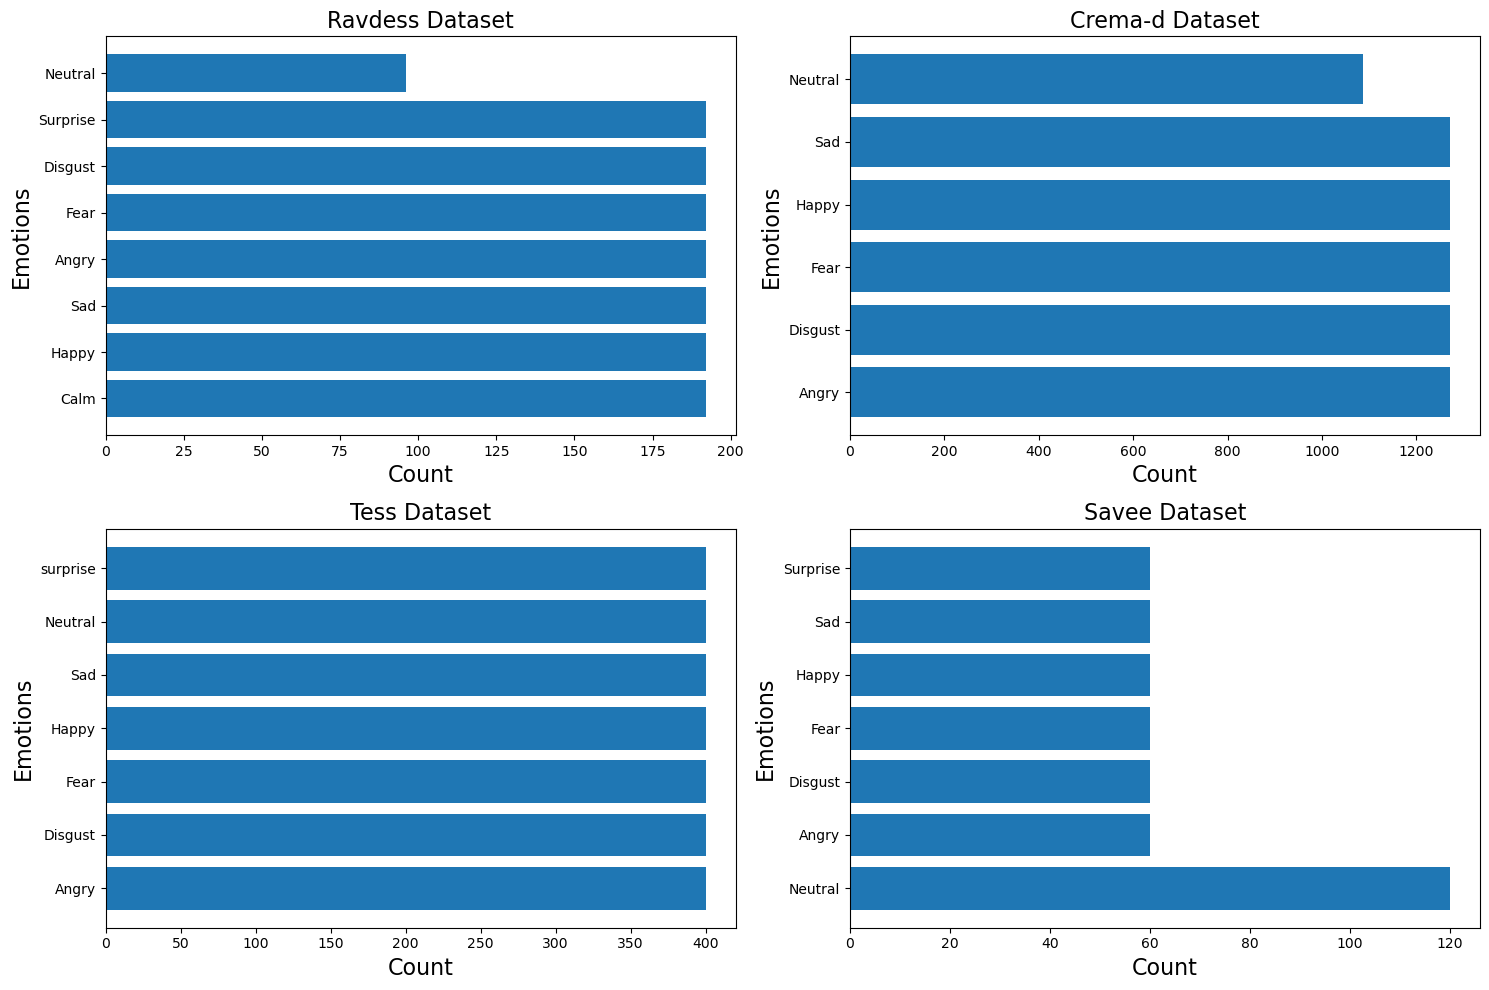

In [ ]:
fig, ax = plt.subplots(2, 2)

fig.set_size_inches((15, 10))

# ravdess dataset
labels1 = ('Calm', 'Happy', 'Sad', 'Angry', 'Fear', 'Disgust', 'Surprise', 'Neutral')
index1 = tuple(range(1, 9))
values1 = ravdess_df['Emotions'].value_counts()
ax[0][0].barh(index1, values1, tick_label=labels1)
ax[0][0].set_title('Ravdess Dataset', size=16)
ax[0][0].set_xlabel('Count', size=16)
ax[0][0].set_ylabel('Emotions', size=16)

# Crema-d dataset
labels2 = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral')
index2 = tuple(range(1, 7))
values2 = Crema_df['Emotions'].value_counts()
ax[0][1].barh(index2, values2, tick_label=labels2)
ax[0][1].set_title('Crema-d Dataset', size=16)
ax[0][1].set_xlabel('Count', size=16)
ax[0][1].set_ylabel('Emotions', size=16)

# Tess dataset
labels3 = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral', 'surprise')
index3 = tuple(range(1, 8))
values3 = Tess_df['Emotions'].value_counts()
ax[1][0].barh(index3, values3, tick_label=labels3)
ax[1][0].set_title('Tess Dataset', size=16)
ax[1][0].set_xlabel('Count', size=16)
ax[1][0].set_ylabel('Emotions', size=16)

# Savee dataset
labels4 = ('Neutral', 'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise')
index4 = tuple(range(1, 8))
values4 = Savee_df['Emotions'].value_counts()
ax[1][1].barh(index4, values4, tick_label=labels4)
ax[1][1].set_title('Savee Dataset', size=16)
ax[1][1].set_xlabel('Count', size=16)
ax[1][1].set_ylabel('Emotions', size=16)

plt.tight_layout()
plt.show()

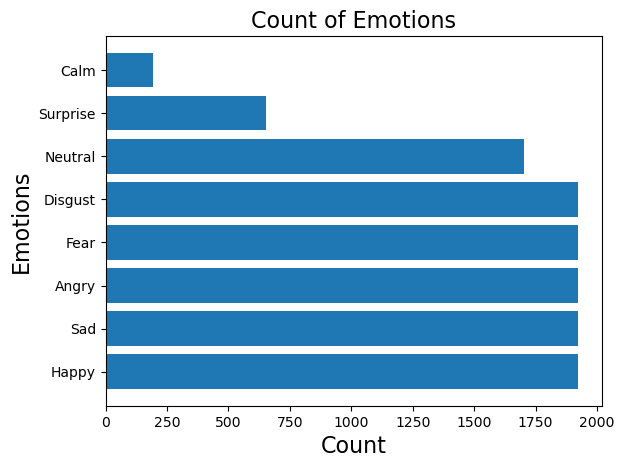

In [ ]:
labels = ('Happy', 'Sad', 'Angry', 'Fear', 'Disgust', 'Neutral', 'Surprise', 'Calm')
index = tuple(range(1, 9))
values = data_path['Emotions'].value_counts()

plt.barh(index, values, tick_label=labels)

plt.title('Count of Emotions', size=16)
plt.xlabel('Count', size=16)
plt.ylabel('Emotions', size=16)
plt.show()

In [153]:
data, sr = librosa.load(data_path['Path'][0])
data, sr

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050)

In [154]:
ipd.Audio(data, rate=sr)  # Neutral

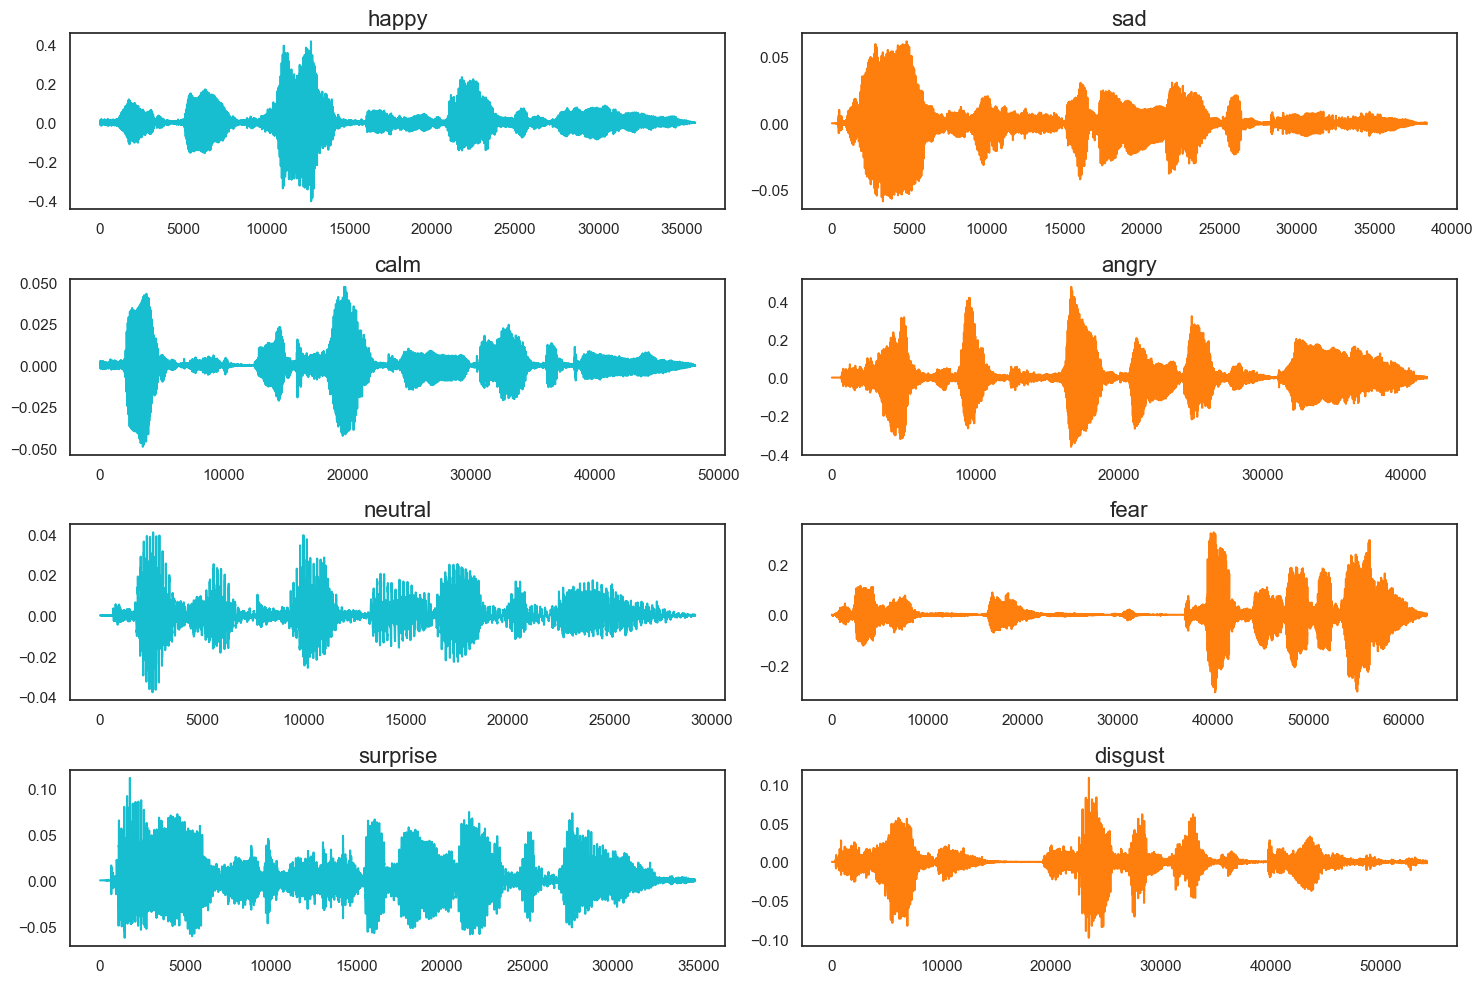

In [185]:
fig, ax = plt.subplots(4, 2)

fig.set_size_inches((15, 10))

# Happy
ax[0][0].plot(pd.Series(librosa.effects.trim(librosa.load(data_path['Path'][76])[0], top_db=30)[0]), color=color_pal[9])
ax[0][0].set_title(data_path['Emotions'][76], size=16)

# Sad
ax[0][1].plot(pd.Series(librosa.effects.trim(librosa.load(data_path['Path'][86])[0], top_db=30)[0]), color=color_pal[1])
ax[0][1].set_title(data_path['Emotions'][86], size=16)

# Calm
ax[1][0].plot(pd.Series(librosa.effects.trim(librosa.load(data_path['Path'][68])[0], top_db=30)[0]), color=color_pal[9])
ax[1][0].set_title(data_path['Emotions'][68], size=16)

# Angry
ax[1][1].plot(pd.Series(librosa.effects.trim(librosa.load(data_path['Path'][92])[0], top_db=30)[0]), color=color_pal[1])
ax[1][1].set_title(data_path['Emotions'][92], size=16)

# Neutral
ax[2][0].plot(pd.Series(librosa.effects.trim(librosa.load(data_path['Path'][0])[0], top_db=30)[0]), color=color_pal[9])
ax[2][0].set_title(data_path['Emotions'][0], size=16)

# Fear
ax[2][1].plot(pd.Series(librosa.effects.trim(librosa.load(data_path['Path'][40])[0], top_db=30)[0]), color=color_pal[1])
ax[2][1].set_title(data_path['Emotions'][40], size=16)

# Surprise
ax[3][0].plot(pd.Series(librosa.effects.trim(librosa.load(data_path['Path'][58])[0], top_db=30)[0]), color=color_pal[9])
ax[3][0].set_title(data_path['Emotions'][58], size=16)

# Disgust
ax[3][1].plot(pd.Series(librosa.effects.trim(librosa.load(data_path['Path'][168])[0], top_db=30)[0]), color=color_pal[1])
ax[3][1].set_title(data_path['Emotions'][168], size=16)

plt.tight_layout()
plt.savefig('files_emotions.png')
plt.show()

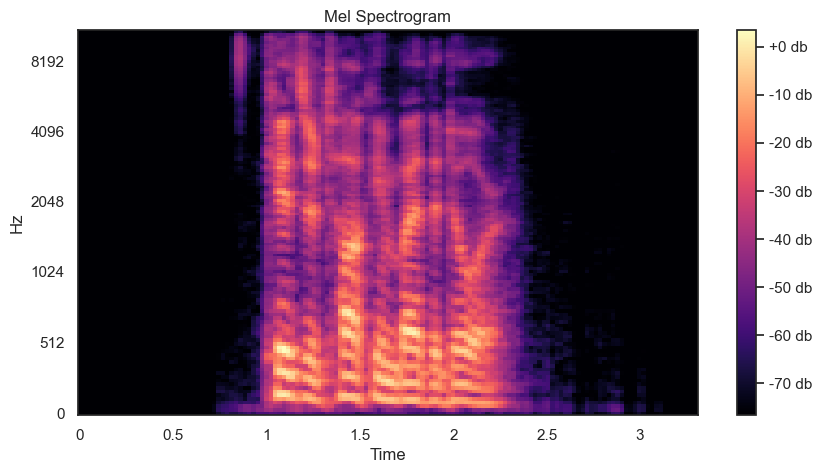

In [156]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f db')
plt.show()

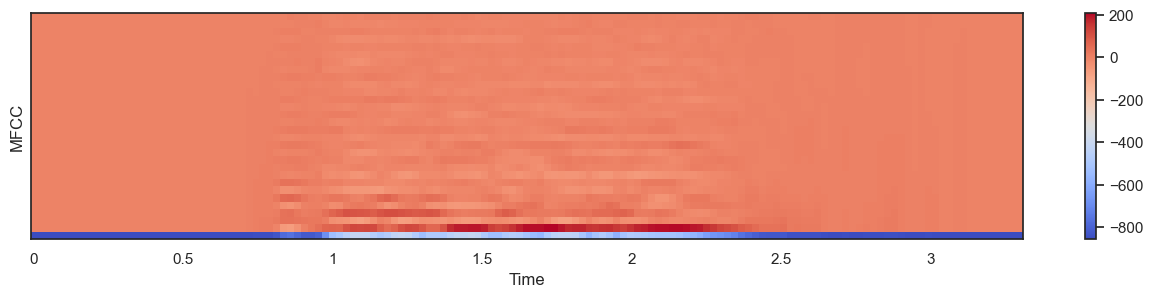

In [187]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3, 1, 1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

# Data augmentation
- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhance its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.

In [222]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
data, sr = librosa.load(data_path['Path'][0])

ipd.Audio(data, rate=sr)

## Add noise to the audio

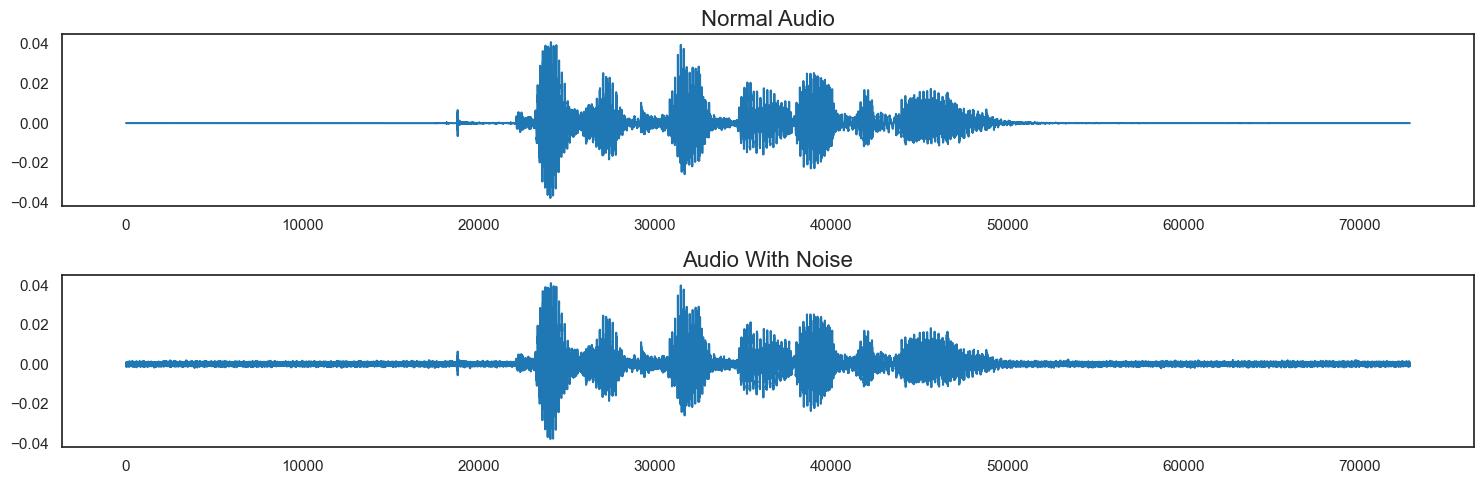

In [224]:
fig, ax = plt.subplots(2, 1)

fig.set_size_inches((15, 5))

# Normal audio
ax[0].plot(pd.Series(data), color=color_pal[0])
ax[0].set_title('Normal Audio', size=16)

# AUDIO WITH NOISE
x = noise(data)
ax[1].plot(pd.Series(x), color=color_pal[0])
ax[1].set_title('Audio With Noise', size=16)

plt.tight_layout()
plt.show()

ipd.Audio(x, rate=sr)

## Stretch audio

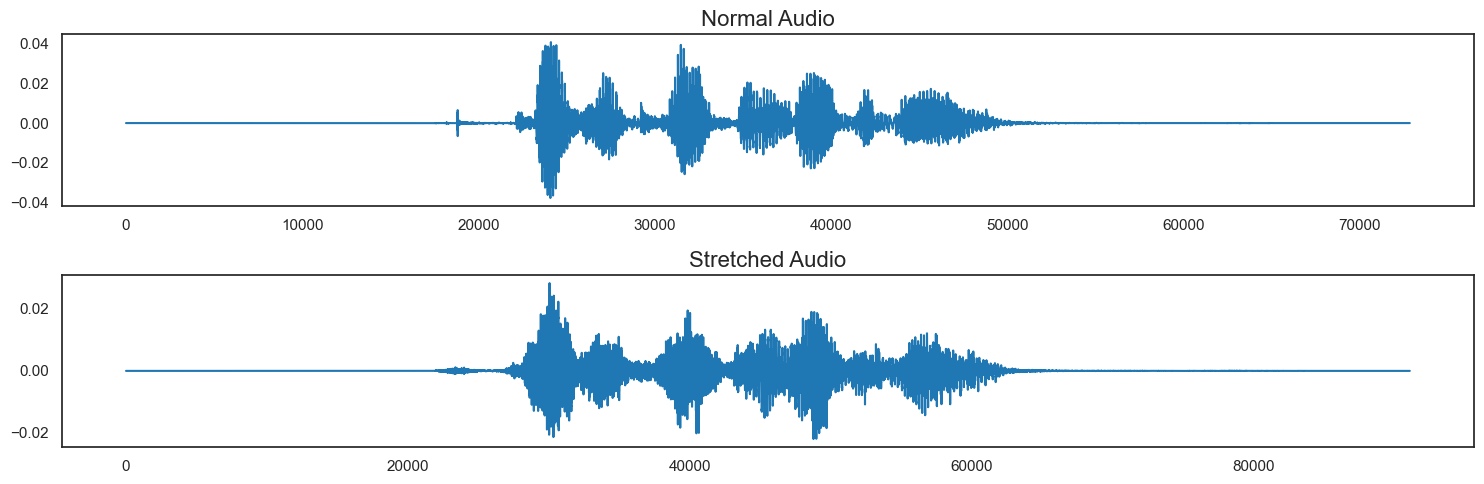

In [225]:
fig, ax = plt.subplots(2, 1)

fig.set_size_inches((15, 5))

# Normal audio
ax[0].plot(pd.Series(data), color=color_pal[0])
ax[0].set_title('Normal Audio', size=16)

# Stretched Audio
x = stretch(data)
ax[1].plot(pd.Series(x), color=color_pal[0])
ax[1].set_title('Stretched Audio', size=16)

plt.tight_layout()
plt.show()

ipd.Audio(x, rate=sr)

## Shift audio

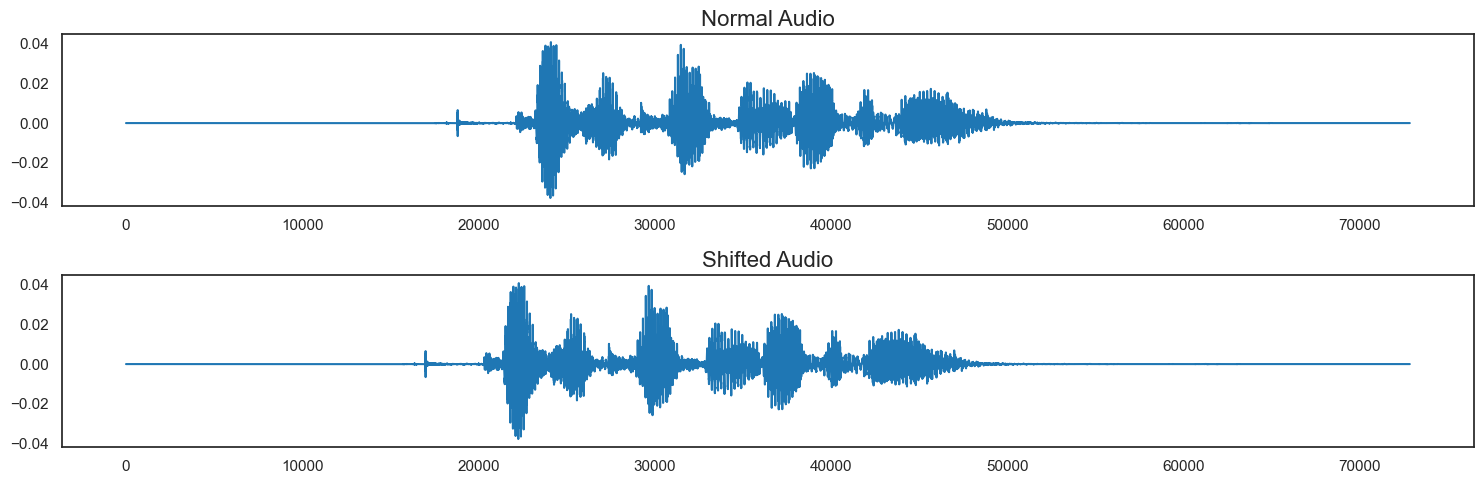

In [226]:
fig, ax = plt.subplots(2, 1)

fig.set_size_inches((15, 5))

# Normal audio
ax[0].plot(pd.Series(data), color=color_pal[0])
ax[0].set_title('Normal Audio', size=16)

# Shifted Audio
x = shift(data)
ax[1].plot(pd.Series(x), color=color_pal[0])
ax[1].set_title('Shifted Audio', size=16)

plt.tight_layout()
plt.show()

ipd.Audio(x, rate=sr)

## Change pitch of the audio

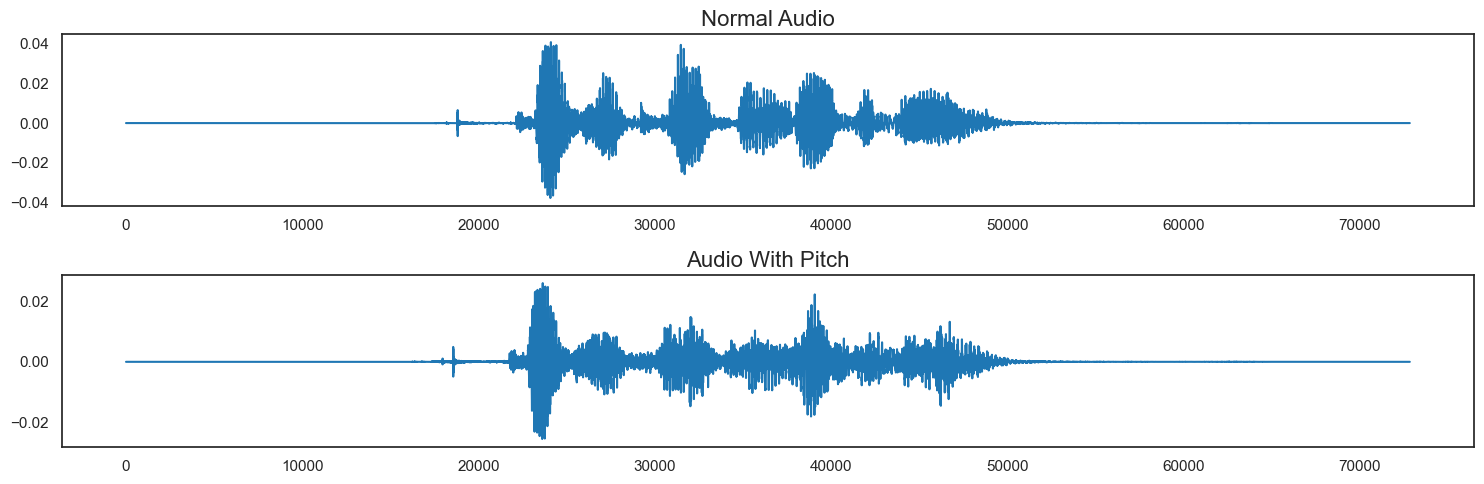

In [227]:
fig, ax = plt.subplots(2, 1)

fig.set_size_inches((15, 5))

# Normal audio
ax[0].plot(pd.Series(data), color=color_pal[0])
ax[0].set_title('Normal Audio', size=16)

# Audio With Pitch
x = pitch(data, sr)
ax[1].plot(pd.Series(x), color=color_pal[0])
ax[1].set_title('Audio With Pitch', size=16)

plt.tight_layout()
plt.show()

ipd.Audio(x, rate=sr)

# Feature extraction

In [24]:
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten:bool=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    result = np.hstack((result,
                      zcr(data, frame_length, hop_length),
                      rmse(data, frame_length, hop_length),
                      mfcc(data, sr, frame_length, hop_length)
                     ))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)

    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))

    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))

    pitched_audio1 = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio1)
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))

    return audio

# Normal way to get features

In [ ]:
import timeit
from tqdm import tqdm

start = timeit.default_timer()
X, Y = [], []

for path, emotion, index in tqdm(zip(data_path.Path, data_path.Emotions, range(data_path.Path.shape[0]))):
    features = get_features(path)
    if index % 500 == 0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

print('Done')

stop = timeit.default_timer()

print('Time:', stop - start)

1it [00:00,  1.46it/s]

0 audio has been processed


502it [01:14,  6.83it/s]

500 audio has been processed


1002it [02:28,  3.16it/s]

1000 audio has been processed


1502it [03:47,  8.87it/s]

1500 audio has been processed


2001it [04:53,  7.21it/s]

2000 audio has been processed


2502it [05:56,  8.32it/s]

2500 audio has been processed


3002it [06:58,  7.39it/s]

3000 audio has been processed


3502it [08:09,  8.61it/s]

3500 audio has been processed


4002it [09:07,  7.42it/s]

4000 audio has been processed


4502it [10:10,  8.28it/s]

4500 audio has been processed


5003it [11:09,  8.43it/s]

5000 audio has been processed


5502it [12:09,  8.84it/s]

5500 audio has been processed


6002it [13:07,  8.08it/s]

6000 audio has been processed


6502it [14:10,  8.04it/s]

6500 audio has been processed


7002it [15:14,  7.97it/s]

7000 audio has been processed


7502it [16:21,  8.79it/s]

7500 audio has been processed


8002it [17:28,  8.32it/s]

8000 audio has been processed


8502it [18:36,  7.76it/s]

8500 audio has been processed


9003it [19:37, 11.95it/s]

9000 audio has been processed


9503it [20:30,  8.54it/s]

9500 audio has been processed


10002it [21:23,  9.04it/s]

10000 audio has been processed


10502it [22:24,  7.56it/s]

10500 audio has been processed


11002it [23:18,  9.57it/s]

11000 audio has been processed


11501it [24:13,  8.48it/s]

11500 audio has been processed


12002it [25:28,  6.80it/s]

12000 audio has been processed


12162it [25:54,  7.82it/s]

Done
Time: 1554.3088678999975


# Faster way to get features
***Parallel way***

In [ ]:
from joblib import Parallel, delayed
import timeit

start = timeit.default_timer()

# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X, Y = [], []

    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X, Y = [], []

for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)

stop = timeit.default_timer()

print('Time:', stop - start)

Time: 419.3921904999879


In [ ]:
len(X), len(Y), data_path.Path.shape

(48648, 48648, (12162,))

# Saving features

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('Datasets/Emotion.csv', index=False)

In [3]:
Emotions = pd.read_csv('/content/drive/MyDrive/dataset/Emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.000000,0.000000,0.064453,0.105469,0.125488,0.266113,0.350098,0.439941,0.547363,0.546387,...,0.089808,0.088329,0.086733,0.085019,0.083187,0.081227,0.079191,0.077032,0.074766,neutral
1,0.247070,0.374512,0.495117,0.496582,0.511230,0.509277,0.507812,0.504883,0.494629,0.504883,...,-3.282296,-2.254726,3.479579,-3.276823,-2.081879,5.026638,4.314040,3.430134,2.370027,neutral
2,0.177734,0.268066,0.363770,0.380371,0.339355,0.323242,0.326660,0.337891,0.430664,0.503906,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
3,0.237793,0.366211,0.492188,0.512207,0.508789,0.486816,0.463379,0.451172,0.476562,0.516602,...,-1.225884,0.583298,-0.870326,-0.903326,0.101325,1.893579,0.819117,-0.835820,-0.004954,neutral
4,0.130371,0.262207,0.422363,0.481445,0.394043,0.404297,0.391602,0.458984,0.554688,0.513672,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [4]:
Emotions['Emotions']

0         neutral
1         neutral
2         neutral
3         neutral
4         neutral
           ...   
48643    surprise
48644    surprise
48645    surprise
48646    surprise
48647    surprise
Name: Emotions, Length: 48648, dtype: object

In [5]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [6]:
Emotions = Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [7]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [8]:
# taking all rows and all cols without last col for X which include features
X = Emotions.iloc[: ,:-1].values
# taking last col for Y, which include the emotions
Y = Emotions['Emotions'].values

In [9]:
Y, len(Y)

(array(['neutral', 'neutral', 'neutral', ..., 'surprise', 'surprise',
        'surprise'], dtype=object),
 48648)

In [10]:
# as this is a multi-class classification problem, we will do one hot encoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [11]:
Y, len(Y)

(array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 48648)

In [12]:
print(Y.shape)
print(X.shape)

(48648, 8)
(48648, 2376)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 8), (9730, 2376), (9730, 8))

In [ ]:
# # reshape for lstm
# X_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# X_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [14]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 8), (9730, 2376), (9730, 8))

In [15]:
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# CNN model

In [16]:
# reshape for CNN_LSTM MODEL
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 8), (9730, 2376, 1), (9730, 8))

#### It is a Convolutional Neural Network (CNN) designed for a multi-class classification with 7 classes. The model is created using the Sequential API, which is a linear stack of layers.

#### 1D CNN architecture.

#### The model consists of several layers, including:

#### (1) Conv1D layers: These are 1D convolutional layers that apply a convolution operation to the input data. The first Conv1D layer has 512 filters with a kernel size of 5 and a stride of 1, and is applied to the input data with a shape of (X_train.shape[1], 1). The input data should be reshaped to this shape before passing it to the model. The remaining Conv1D layers have different numbers of filters and kernel sizes, as shown in the code.

#### (2) BatchNormalization layers: These layers normalize the activations of the previous layer before passing them to the next layer. This helps to reduce internal covariate shift and improve the training stability.

#### (3) MaxPool1D layers: These layers perform max pooling operation, which reduces the spatial dimensions of the input data. The pool size and stride are set to 5 in this code.

#### (4) Dropout layers: These layers randomly drop out a fraction of the input units during training, which helps to prevent overfitting. The dropout rate is set to 0.2 in this code.

#### (5) Flatten layer: This layer flattens the input data from a 3D tensor to a 1D tensor, which can be passed to a fully connected layer.

#### (6) Dense layers: These are fully connected layers that connect every neuron in the previous layer to every neuron in the next layer. The first Dense layer has 512 neurons with a ReLU activation function, and the output layer has 7 neurons with a softmax activation function.

#### The model is compiled with an optimizer (Adam), a loss function (categorical_crossentropy), and an evaluation metric (accuracy).

In [32]:
from keras.layers import Dropout, MaxPool1D, Flatten, Dense
from keras.layers import Conv1D, BatchNormalization

model = tf.keras.Sequential([
    Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_traincnn.shape[1], 1)),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),

    Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),

    Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

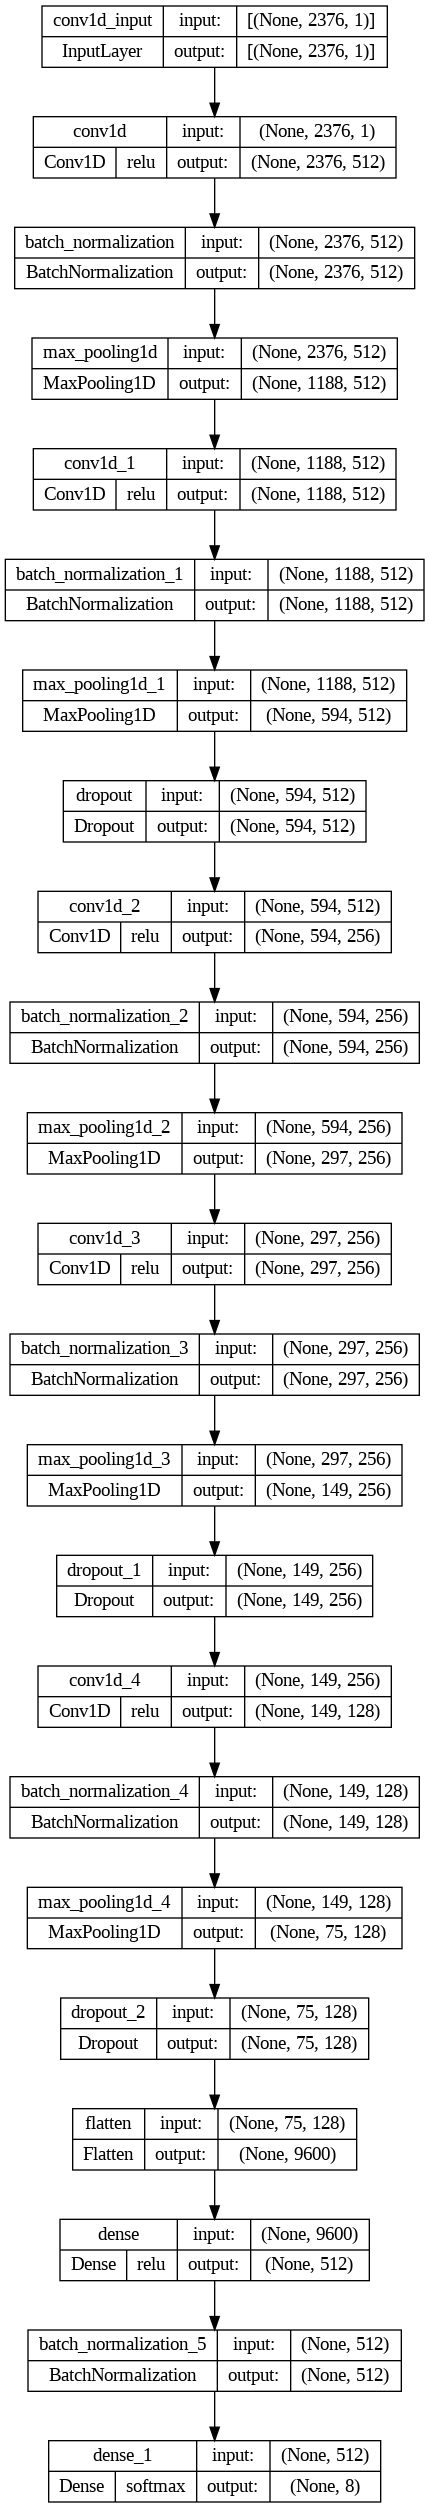

In [62]:
from keras.utils import plot_model

plot_model(
    model, show_shapes=True, show_layer_names=True, to_file='model_vertical.png',
    show_layer_activations=True,
)

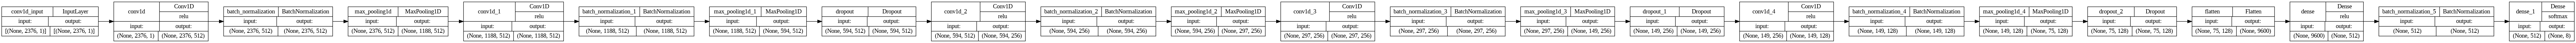

In [63]:
from keras.utils import plot_model

plot_model(
    model, show_shapes=True, show_layer_names=True, to_file='model_horizontal.png',
    rankdir="LR", show_layer_activations=True,
)

In [76]:
# !pip install visualkeras # To install the library

# import visualkeras

# visualkeras.layered_view(model).save('model_visualization.png')

In [1]:
# from neuralplot import ModelPlot

# visual = ModelPlot(model=model, grid=False, connection=True, linewidth=0.1)
# visual.show()

In [ ]:
history = model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,
                  callbacks=[early_stop, lr_reduction, model_checkpoint])

Epoch 1/50
609/609 [==============================] - 220s 337ms/step - loss: 1.4201 - accuracy: 0.4691 - val_loss: 1.2375 - val_accuracy: 0.5216 - lr: 0.0010
Epoch 2/50
609/609 [==============================] - 198s 324ms/step - loss: 1.1007 - accuracy: 0.5769 - val_loss: 1.1741 - val_accuracy: 0.5509 - lr: 0.0010
Epoch 3/50
609/609 [==============================] - 197s 324ms/step - loss: 0.9736 - accuracy: 0.6252 - val_loss: 1.0184 - val_accuracy: 0.6120 - lr: 0.0010
Epoch 4/50
609/609 [==============================] - 205s 337ms/step - loss: 0.8684 - accuracy: 0.6704 - val_loss: 0.9275 - val_accuracy: 0.6451 - lr: 0.0010
Epoch 5/50
609/609 [==============================] - 197s 323ms/step - loss: 0.7253 - accuracy: 0.7271 - val_loss: 0.8552 - val_accuracy: 0.6803 - lr: 0.0010
Epoch 6/50
609/609 [==============================] - 197s 324ms/step - loss: 0.6160 - accuracy: 0.7701 - val_loss: 0.6966 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 7/50
609/609 [==========================

305/305 [==============================] - 15s 46ms/step - loss: 0.0783 - accuracy: 0.9818
Accuracy of our model on test data : 98.18088412284851 %


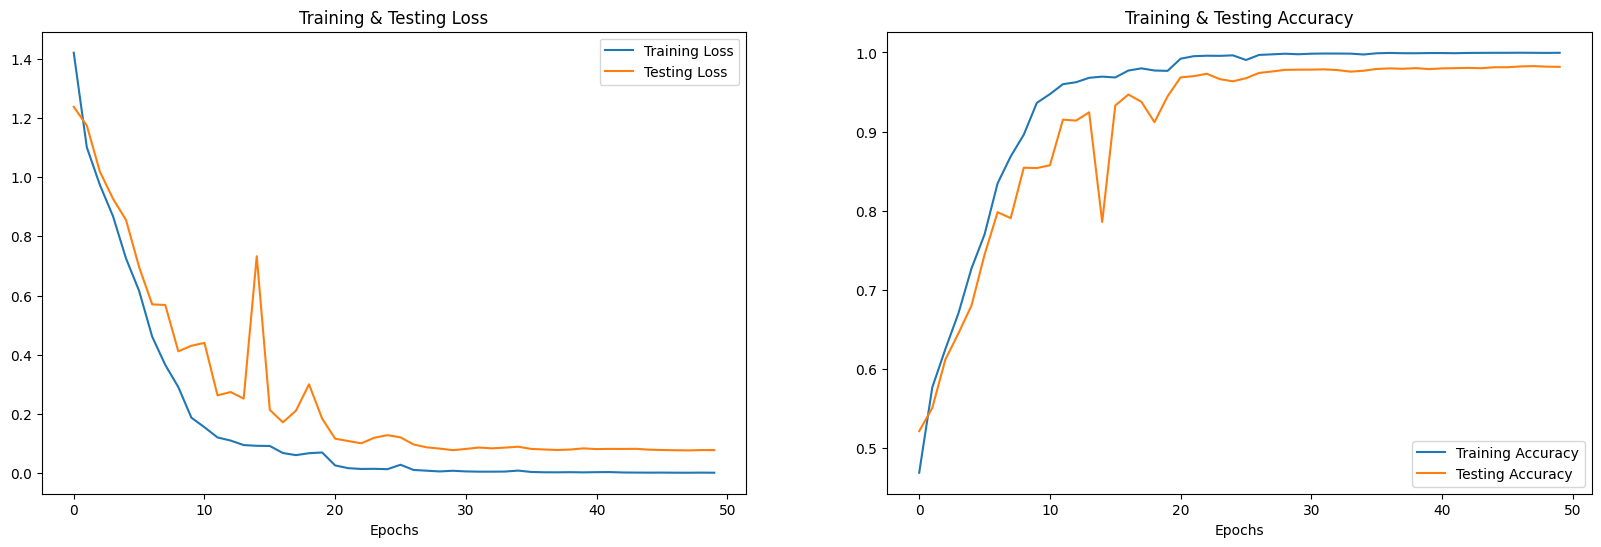

In [ ]:
print("Accuracy of our model on test data :", model.evaluate(x_testcnn, y_test)[1] * 100, "%")

epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches((20, 6))

ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.tight_layout()
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 [==============================] - 14s 45ms/step


,Predicted Labels,Actual Labels
0,calm,calm
1,disgust,disgust
2,fear,fear
3,angry,angry
4,fear,fear
5,angry,angry
6,angry,angry
7,fear,fear
8,angry,angry
9,fear,fear


In [ ]:
df0

,Predicted Labels,Actual Labels
0,calm,calm
1,disgust,disgust
2,fear,fear
3,angry,angry
4,fear,fear
...,...,...
9725,angry,angry
9726,sad,sad
9727,neutral,neutral
9728,sad,sad


Results of best model

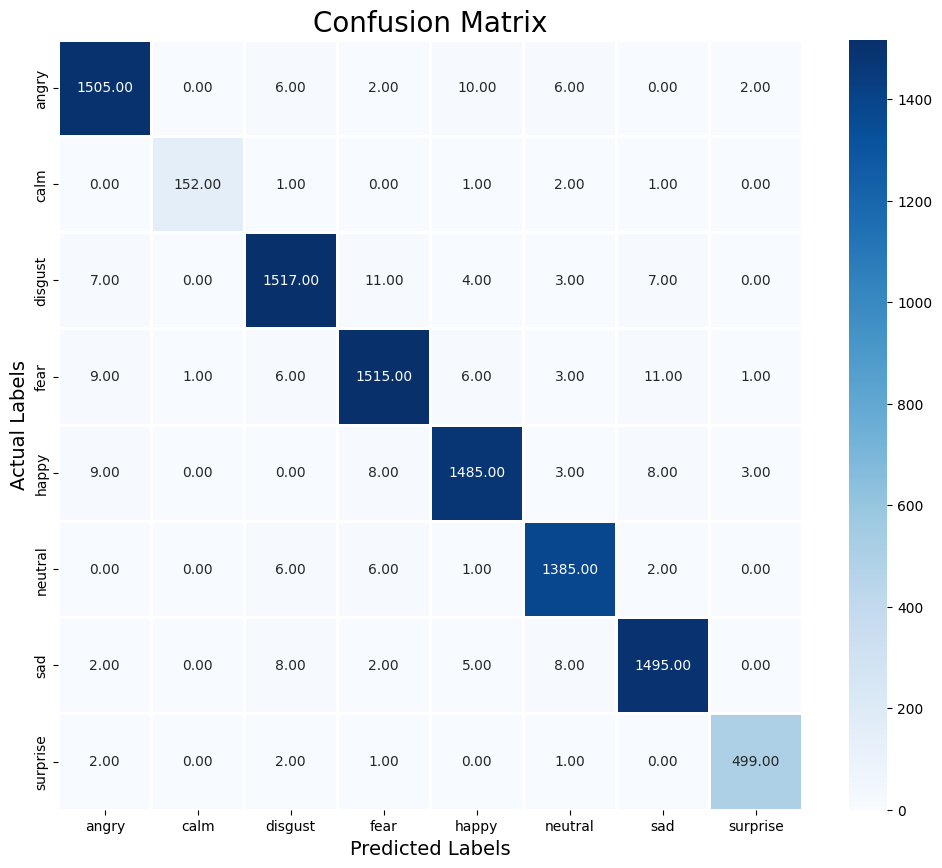

              precision    recall  f1-score   support

       angry       0.98      0.98      0.98      1531
        calm       0.99      0.97      0.98       157
     disgust       0.98      0.98      0.98      1549
        fear       0.98      0.98      0.98      1552
       happy       0.98      0.98      0.98      1516
     neutral       0.98      0.99      0.99      1400
         sad       0.98      0.98      0.98      1520
    surprise       0.99      0.99      0.99       505

    accuracy                           0.98      9730
   macro avg       0.98      0.98      0.98      9730
weighted avg       0.98      0.98      0.98      9730



In [ ]:
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential, model_from_json

model_json = model.to_json()

with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("CNN_model_weights.keras")

print("Saved model to disk")

Saved model to disk


In [19]:
from keras.models import Sequential, model_from_json

json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/best_model1_weights.keras")

print("Loaded model from disk")

Loaded model from disk


In [20]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

305/305 [==============================] - 19s 48ms/step - loss: 0.0854 - accuracy: 0.9790
accuracy: 97.90%


# Saving and Loading our Standard Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [ ]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

print("Done")

Done


# Test script
* That can predict new record

In [21]:
from keras.models import Sequential, model_from_json

json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/best_model1_weights.keras")

print("Loaded model from disk")

Loaded model from disk


In [22]:
import pickle

with open('/content/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/content/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

print("Done")

Done


In [23]:
def get_predict_feat(path):
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(d)
    result = np.array(res)
    result = np.reshape(result, newshape=(1, 2376))
    i_result = scaler2.transform(result)
    final_result = np.expand_dims(i_result, axis=2)

    return final_result

In [26]:
res = get_predict_feat("/content/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [27]:
def prediction(path1):
    res = get_predict_feat(path1)
    predictions = loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    return y_pred[0][0]

In [29]:
prediction("/content/03-01-01-01-01-01-02.wav")

1/1 [==============================] - 1s 640ms/step


'neutral'

In [ ]:
prediction("/content/03-01-01-01-01-01-01.wav")

1/1 [==============================] - 0s 26ms/step


'neutral'

In [ ]:
prediction("/content/03-01-05-01-02-02-01.wav")

1/1 [==============================] - 0s 37ms/step


'angry'

In [ ]:
prediction("/content/03-01-04-02-02-02-21.wav")

1/1 [==============================] - 0s 26ms/step


'sad'

In [ ]:
prediction("/content/03-01-06-01-02-02-02.wav")

1/1 [==============================] - 0s 25ms/step


'fear'

In [ ]:
prediction("/content/03-01-08-01-01-01-01.wav")

1/1 [==============================] - 0s 25ms/step


'surprise'

In [ ]:
prediction("/content/03-01-07-01-01-01-01.wav")

1/1 [==============================] - 0s 36ms/step


'disgust'

In [30]:
prediction("/content/03-01-02-01-02-01-01.wav")

1/1 [==============================] - 0s 28ms/step


'calm'

In [31]:
prediction("/content/03-01-03-01-01-01-01.wav")

1/1 [==============================] - 0s 27ms/step


'happy'